In [1]:
MATCH_TO_EXAMINE = '2023-wimbledon-1301'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

import tennis_data
import dynamic_model1 as dm1

In [3]:
data_raw = tennis_data.load_2023()

alcaraz_match = data_raw[data_raw['match_id'] == MATCH_TO_EXAMINE]

player1_name = alcaraz_match['player1'].values[0]
player2_name = alcaraz_match['player2'].values[0]

print(len(alcaraz_match))

300


In [4]:
POINT_WIN_BASE_MOMENTUM_INCREASE = 1 # The minimum increase to momentum a player gets from winning a point
POINT_WIN_MOMENTUM_INCREASE_DELTA = 0.25 # Every time a player wins a point after winning the previous point, the momentum gain increases this much
POINT_LOSS_MOMENTUM_DECREASE = 1.5 # Every time a player loses a point, lose this much momentum
POINT_LOSS_DISADVANTAGE_MULTIPLIER = 0.75 # If the player loses a point when not serving, multiply the loss by this amount
POINT_LOSS_ADVANTAGE_MULTIPLIER = 1.25 # If the player loses a point when not serving, multiply the loss by this amount
POINT_WIN_ADVANTAGE_MULTIPLIER = 1 # If the player servs and wins, multiply the momemtum gain by this amount
POINT_WIN_DISADVANTAGE_MULTIPLIER = 1.25 # If the player servs and wins, multiply the momemtum gain by this amount

# Reset momentum after each game?
# Have a 'GAMES_WON_MOMENTUM_INCREASE'?
def calculate_momentum(match_data, player):
    """Calculates the momentum of the given player at each point in the game"""
    point_victor_array = match_data['point_victor'].values
    server_array = match_data['server'].values

    win_streak = 0
    player_momentum_array = []
    player_current_momentum = 0

    for index, winner in enumerate(point_victor_array):
        has_advantage = server_array[index] == player

        if winner == player:
            win_streak += 1

            advantage_multiplier = POINT_WIN_ADVANTAGE_MULTIPLIER if has_advantage else POINT_WIN_DISADVANTAGE_MULTIPLIER
            
            player_current_momentum += (POINT_WIN_BASE_MOMENTUM_INCREASE + POINT_WIN_MOMENTUM_INCREASE_DELTA * win_streak) * advantage_multiplier
        else:
            # Penalize the player's momentum and reset the win streak
            win_streak = 0

            advantage_multiplier = POINT_LOSS_ADVANTAGE_MULTIPLIER if has_advantage else POINT_LOSS_DISADVANTAGE_MULTIPLIER

            player_current_momentum -= POINT_LOSS_MOMENTUM_DECREASE * advantage_multiplier

            player_current_momentum = max(0, player_current_momentum)

        player_momentum_array.append(player_current_momentum)

    return player_momentum_array

In [5]:
p1_momentum = calculate_momentum(alcaraz_match, 1)
p2_momentum = calculate_momentum(alcaraz_match, 2)

y_lim = max(max(p1_momentum), max(p2_momentum))

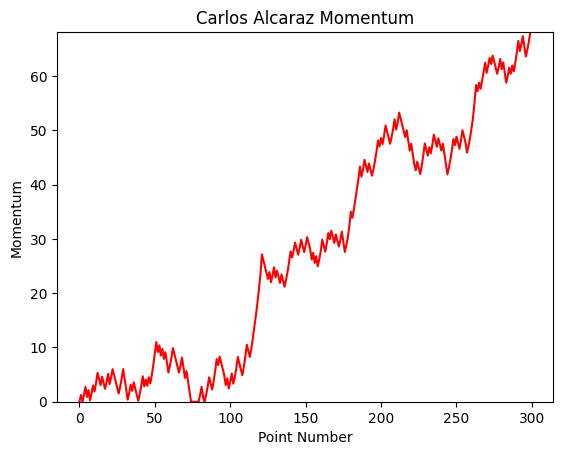

In [6]:
plt.title(f"{player1_name} Momentum")
plt.plot(list(range(len(p1_momentum))), p1_momentum, color="red")
plt.xlabel("Point Number")
plt.ylabel("Momentum")
plt.ylim(0, y_lim)
plt.show()

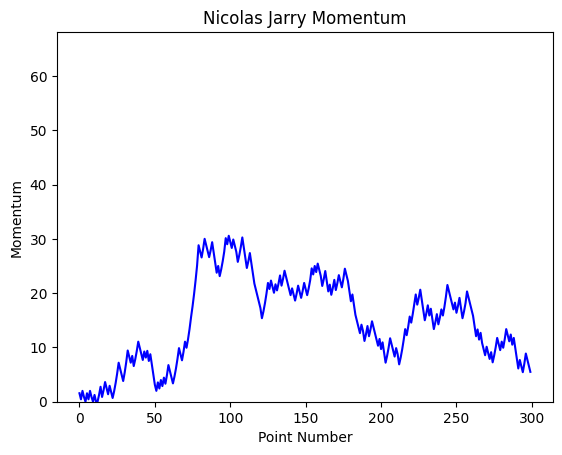

In [7]:
plt.title(f"{player2_name} Momentum")
plt.plot(list(range(len(p2_momentum))), p2_momentum, color="blue")
plt.xlabel("Point Number")
plt.ylabel("Momentum")
plt.ylim(0, y_lim)
plt.show()

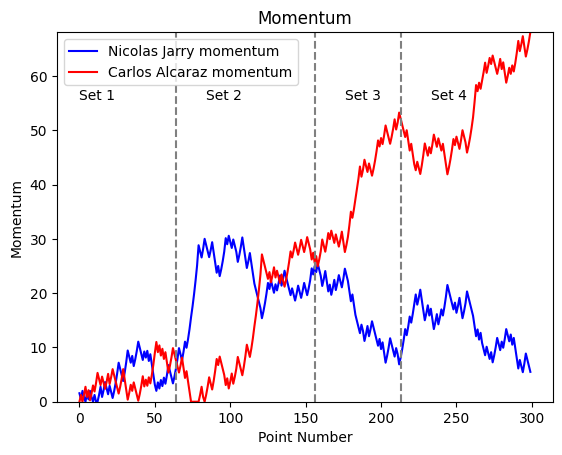

In [8]:
set_change_points = []

old_entry = 1
for index, entry in enumerate(alcaraz_match['set_no']):
    if entry != old_entry:
        set_change_points.append(index + 1)
        old_entry = entry

plt.title(f"Momentum")
plt.plot(list(range(len(p2_momentum))), p2_momentum, color="blue", label=f"{player2_name} momentum")
plt.plot(list(range(len(p1_momentum))), p1_momentum, color="red", label=f"{player1_name} momentum")

plt.text(0, 55, f"Set 1", verticalalignment='bottom')
for index, value in enumerate(set_change_points):
    plt.axvline(x=value, color='gray', linestyle='--')
    plt.text(value + 20, 55, f"Set {index + 2}", verticalalignment='bottom')

plt.xlabel("Point Number")
plt.ylabel("Momentum")
plt.ylim(0, y_lim)
plt.legend()
plt.show()